In [1]:
import pandas as pd
import numpy as np
import math
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import ensemble


train_data = pd.read_csv('D:/Kaggle_Home/train.csv')
test_data = pd.read_csv('D:/Kaggle_Home/test.csv')


In [2]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Analysing the Target Variable

In [3]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### We can visualize the existence of a considerable positive skewness and deviation from the normal distribution

C:\Users\Surya\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


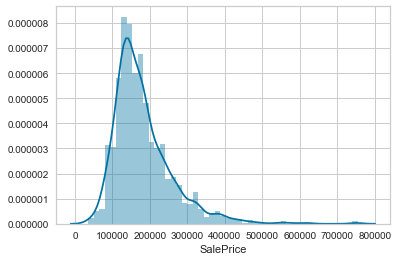

In [4]:
sns.distplot(train_data['SalePrice']);

## Null Value Analysis

<Figure size 21600x21600 with 0 Axes>

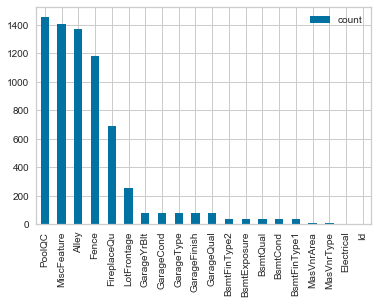

In [5]:
fig = plt.gcf()
fig.set_size_inches(300,300)

n=pd.DataFrame(train_data.isnull().sum())
n.columns = ['count']
n.sort_values('count', ascending=False).head(20).plot(kind='bar')

## Dropping features with more than half the number of Missing Values

In [6]:
train_data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'],axis=1, inplace=True)

## Overall Correlation Matrix

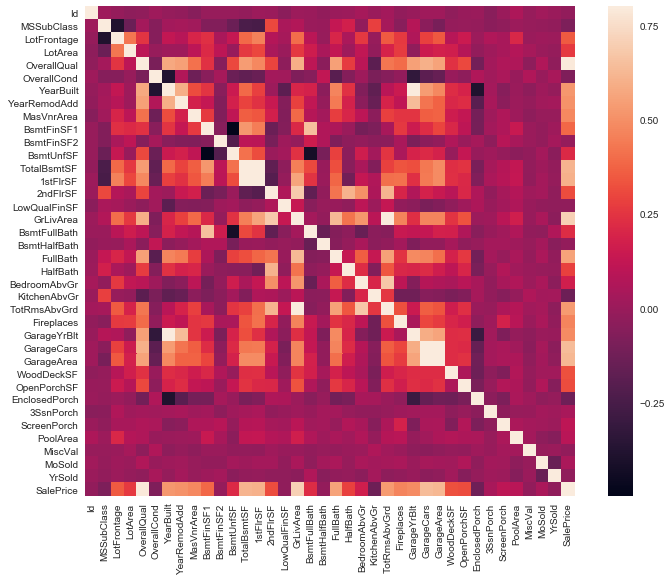

In [7]:
# calculate the correlation matrix
corr = train_data.corr()

# plot the heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,vmax=.8, square=True)



## Correlation Table for better Readability

In [8]:
cmap =sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

## Dropping Features which have very less correlation with respect to the target variable

In [9]:
train_data.drop(['Id','Utilities', 'RoofMatl', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF','BsmtFullBath', 
               'BsmtHalfBath', 'Functional', 'GarageCond', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal'],
              axis=1, inplace=True)

## Important Variable Relationships

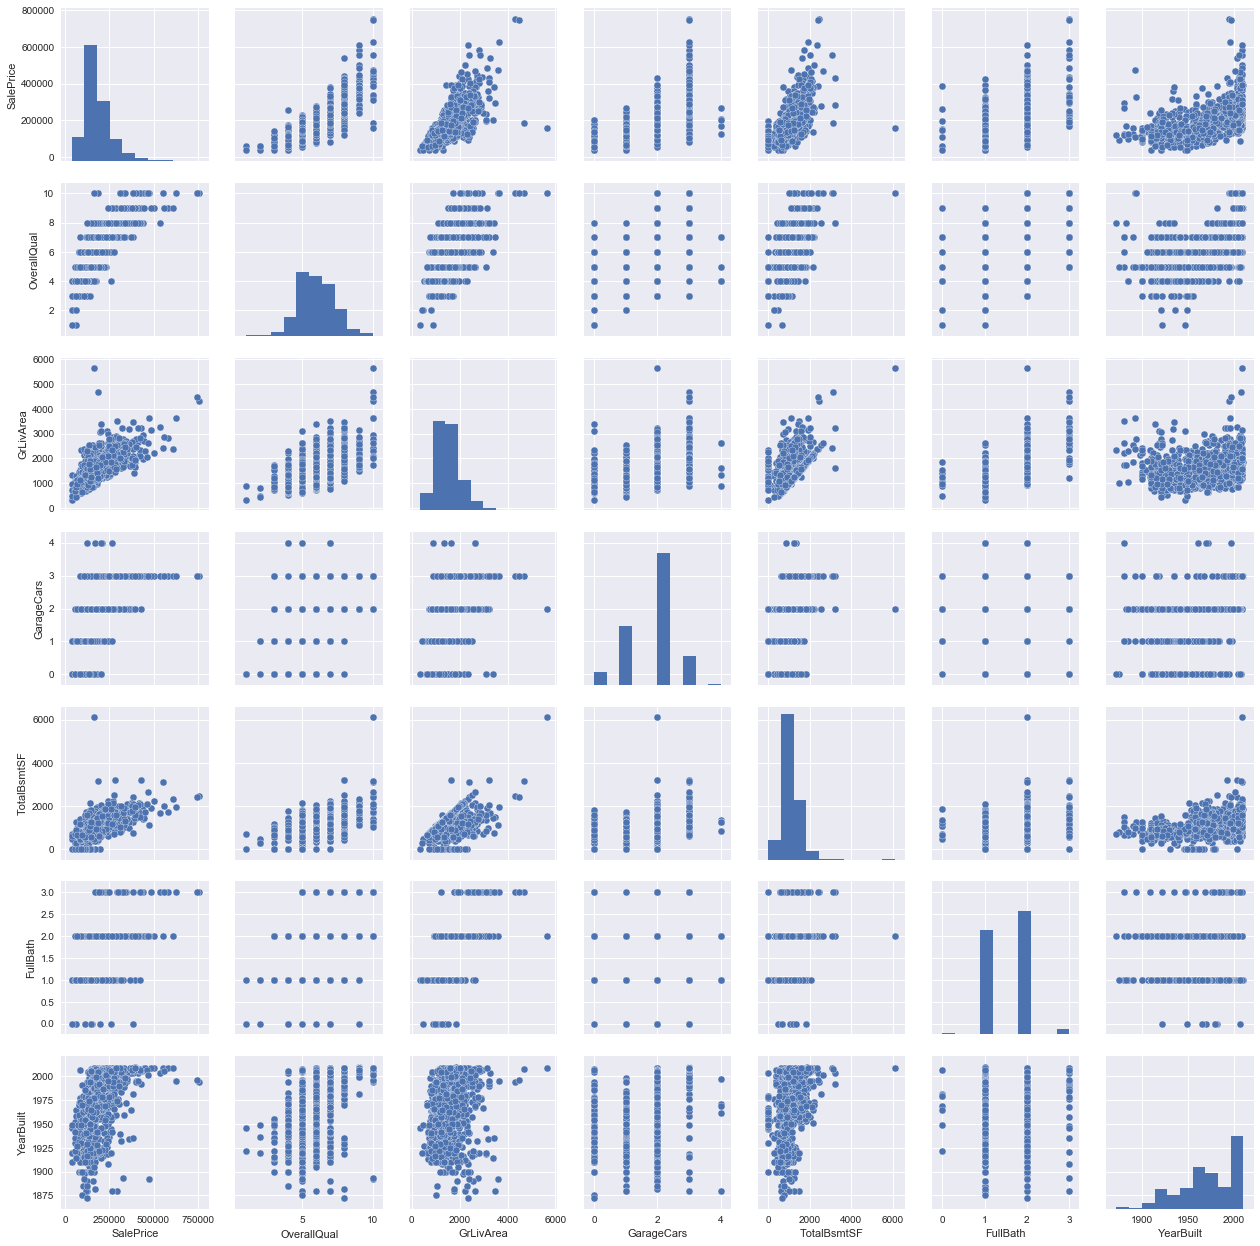

In [10]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

## Null Value Treatment

In [11]:
fig = plt.gcf()
fig.set_size_inches(300,300)

n=pd.DataFrame(train_data.isnull().sum())
n.columns = ['count']
print n[n.sum(axis=1)>0]

              count
LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81


<Figure size 21600x21600 with 0 Axes>

In [12]:
train_data['LotFrontage']=train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean())

train_data['MasVnrType']=train_data['MasVnrType'].fillna(train_data['MasVnrType'].mode()[0])

train_data['MasVnrArea']=train_data['MasVnrArea'].fillna(train_data['MasVnrArea'].mode()[0])

train_data['Electrical']=train_data['Electrical'] .fillna(train_data['Electrical'].mode()[0])

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_data[col]=train_data[col].fillna('New Category')
    
for col in ('GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual'):
    train_data[col]=train_data[col].fillna('New Category')

## Encoding the categorical variables

In [13]:

class MCLEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
X=MCLEncoder(columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                        'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual','SaleType','SaleCondition',
                       'PavedDrive','KitchenQual','Electrical','CentralAir','HeatingQC','Foundation',
                       'ExterCond','ExterQual','MasVnrType','Exterior1st','Exterior2nd','RoofStyle','MSZoning',
                       'Street','LotShape','LandContour','LotConfig',   'LandSlope',  'Neighborhood','Condition1',
                        'Condition2','BldgType','HouseStyle'  ]).fit_transform(train_data)


## Applying Log Transformation on Sale Price Variable

In [ ]:
y=np.log(X['SalePrice'])


X.drop(['SalePrice'],axis=1, inplace=True)

## Gradient Boosting Regressor

In [14]:

GBest = ensemble.GradientBoostingRegressor(n_estimators=4000, learning_rate=0.01, max_depth=8, max_features='sqrt',
                                                min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X, y)


## Model Evaluation

In [15]:

prediction_train = GBest.predict(X)
print('R2: {}'.format(r2_score(prediction_train, y)))

scores = cross_val_score(GBest, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2: 0.979124086944
Accuracy: 0.90 (+/- 0.03)


In [16]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

rms = rmsle(y, prediction_train)

print "RMSE is : ", rms

RMSE is :  0.00444634116955


## Displaying top 10 Important Features for the model

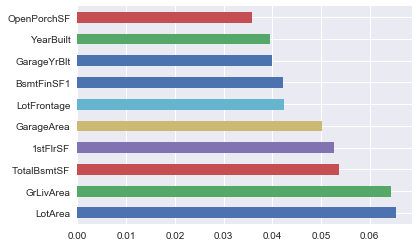

In [17]:
# Displaying the Feature Importance
(pd.Series(GBest.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh')) 